This notebook contains a PyTorch implementation for the paper "Solving stochastic differential equations and Kolmogorov equations by means of deep learning" by Christian Beck et al, original paper can be found [here](https://arxiv.org/pdf/1806.00421.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
# Honestly though I wanted to do this with JAX+STAX (or FLAX if anyone ever had the guts to use a 3 month old library for something like this)

In [2]:
class ItoDiffusion:
    def __init__(self, mu, sigma, N):
        # Initializing the Ito Diffusion, given as a batch of size J
        # mu    :: R^dxJ -> R^dxJ
        # sigma :: R^dxJ -> R^dxdxJ (In general, Ito diffusions can have sigma -> R^dxpxJ, i.e. we can use Brownian increments other of dimension p=/=d)
        # where J is the batch size
        # N :: Int (Number of points in discretization)
        self.mu = mu
        self.sigma = sigma
        self.N = N
    
    def sample(self, x, T):
        # Generate J samples of X_T^x
        # x :: R^dxJ
        dt        = T/self.N
        self.d    = x.size(1)
        batchsize = x.size(0)
        for i in range(self.N):
            x = x + self.mu(x)*dt + self.sigma(x)*mvn(torch.zeros(self.d), dt*torch.eye(self.d)).sample([batchsize])
        return x

In [3]:
class FCNN(nn.Module):
    def __init__(self, dim, hidden_layers):
        # dim    :: Int (Input dimension and also neurons in each hidden layer)
        # hidden :: Int (Number of hidden layers)
        super().__init__()
        self.model = nn.Sequential()
        for i in range(hidden_layers):
            self.model.add_module("Hidden"+str(i), nn.Linear(dim,dim))
            self.model.add_module("Batch norm "+str(i),nn.BatchNorm1d(dim))
            self.model.add_module("Actvation "+str(i),nn.Tanh())
        self.model.add_module("Output",nn.Linear(dim,1))
        

    def forward(self,x):
        # x :: R^d (Spatial point)
        return self.model(x)
        # I know, this makes is harder to debug comparing to running the 
        # input through each layer separately

In [10]:
def Lp_rel_error(neural_net, exact_sol, a,b,d, N,p):
    # neural_net :: FCNN (instance of neural network)
    # exact_sol  :: RxR^d -> R (exact solution of the PDE)
    # a          :: Float (a in [a,b]^d)
    # b          :: Float (b in [a,b]^d)
    # d          :: Int (d in [a,b]^d)
    # N          :: Int (Number of points to sample in the MC estimate)
    # p          :: Int (p in the Lp)
    spatial_points = (a-b)*torch.rand(N,d) + b
    u_exact        = exact_sol(spatial_points)
    return float((torch.mean(torch.abs((neural_net(spatial_points)[:,0] - u_exact)/u_exact).pow(p))).pow(1/p))

Step 0 Relative L1 error is 1.005967140197754, Relative L2 error is 1.0059826374053955
Step 100 Relative L1 error is 0.975290060043335, Relative L2 error is 0.9741851091384888
Step 200 Relative L1 error is 0.9480270147323608, Relative L2 error is 0.9481109380722046
Step 300 Relative L1 error is 0.8965862989425659, Relative L2 error is 0.8972426652908325
Step 400 Relative L1 error is 0.8158047199249268, Relative L2 error is 0.8163891434669495
Step 500 Relative L1 error is 0.7450165748596191, Relative L2 error is 0.7456261515617371
Step 600 Relative L1 error is 0.656400203704834, Relative L2 error is 0.65682053565979
Step 700 Relative L1 error is 0.5902929306030273, Relative L2 error is 0.590087354183197
Step 800 Relative L1 error is 0.5266848206520081, Relative L2 error is 0.5266625881195068
Step 900 Relative L1 error is 0.4649980962276459, Relative L2 error is 0.4646320044994354
Step 1000 Relative L1 error is 0.4117719233036041, Relative L2 error is 0.4119783341884613
Step 1100 Relativ

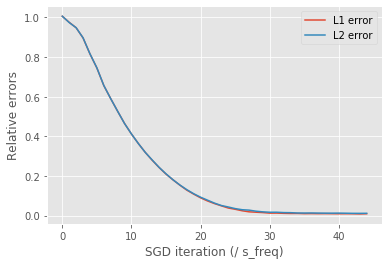

In [33]:
# Heat equation approximation
T,N   = 1,1      # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 0,1        # a,b in [a,b]^d
d   = 10         # d   in [a,b]^d
s   = 3          # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 4500       # SGD iterations
J   = 8192       # Batch size
s_freq = 100     # Frequency at which we record losses

learning_rate = 0.001

# The Ito diffusion corresponding to the Heat equation is Brownian motion. Here we define the initial condition as 
# u(0,x)=||x||2 (squared Euclidean norm) and via an Ansatz you can get the exact solution as u(t,x) = ||x||2 + 2td
brownian_motion = ItoDiffusion(lambda x: torch.zeros(x.size(0),x.size(1)), lambda x: torch.sqrt(torch.tensor(2.0)), 1)
phi = lambda x: torch.norm(x,2,1)**2
u   = lambda x: phi(x) + 2.0*T*d

# Creating our neural network model
model = FCNN(d,s-1)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25000, gamma=0.1)

L1_errors = []
L2_errors = []

for i in range(m):
    model.train()
    eta  = (a-b)*torch.rand(J,d) + b
    optimizer.zero_grad()
    X_T  = brownian_motion.sample(eta,T)
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i%100 == 0:
        model.eval()
        L1_errors.append(Lp_rel_error(model, u, a,b,d, 1000,1))
        L2_errors.append(Lp_rel_error(model, u, a,b,d, 1000,2))
        print("Step {} Relative L1 error is {}, Relative L2 error is {}".format(i,L1_errors[-1],L2_errors[-1]))
        
        
plt.plot(range(len(L1_errors)),L1_errors)
plt.plot(range(len(L2_errors)),L2_errors)
plt.ylabel("Relative errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1 error", "L2 error"])
plt.show()

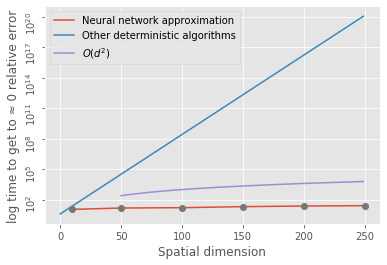

In [26]:
ds = [10,50,100,150,200,250]
times = []
m_ds = 1000

def train_step(d):
    start=time.time()
    for i in range(m_ds):
        eta_ds = (a-b)*torch.rand(J,d) + b
        optimizer.zero_grad()
        X_T  = brownian_motion.sample(eta,T)
        loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
        loss.backward()
        optimizer.step()
        scheduler.step()
    return time.time()-start
    
    
for d in ds:
    times.append(train_step(d))


plt.semilogy(ds,times)
plt.ylabel("log time (*C) to get to ≈ 0 relative error")
plt.xlabel("Spatial dimension")
plt.yticks(rotation='vertical')
plt.semilogy(np.arange(250),4*np.exp(0.18*np.arange(250)))
plt.semilogy(np.arange(250)[50:],0.1*np.arange(250)[50:]**2)
plt.legend(["Neural network approximation","Other deterministic algorithms","$O(d^2)$"])
plt.semilogy(ds,times,'o')
plt.show()
# If you made it this far maybe consider following me on Twitter @naxaal :)